<a href="https://colab.research.google.com/github/Shreya-Mendi/XAI/blob/Colab/Mechanistic_interpretability/guesser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === Dependencies ===
import random, math, time, itertools
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
# set seed
random.seed(0); np.random.seed(0); torch.manual_seed(0)

# === Word list (small) ===
# Replace with a larger word list if you like
WORDS = ["crane","slate","trace","crate","apple","glare","plane","stare","store","stone",
         "later","hello","world","spear","shiny","piano","other","their","there","berry",
         "cigar","rebut","sissy","awake","never","adieu","audio","about","trace","later"]
WORDS = sorted(list(set(w for w in WORDS if len(w)==5)))
V = len(WORDS)
print("Vocab size:", V)

# maps
LETTER2IDX = {c:i for i,c in enumerate("abcdefghijklmnopqrstuvwxyz")}
WORD2IDX = {w:i for i,w in enumerate(WORDS)}
IDX2WORD = {i:w for w,i in WORD2IDX.items()}

# --- wordle feedback function
def wordle_feedback(target, guess):
    fb = [0]*5
    tlist = list(target)
    # greens
    for i in range(5):
        if guess[i] == target[i]:
            fb[i] = 2
            tlist[i] = None
    # yellows
    for i in range(5):
        if fb[i] == 0:
            ch = guess[i]
            if ch in tlist:
                fb[i] = 1
                tlist[tlist.index(ch)] = None
    return fb

# --- simulate games and build examples
def generate_examples(N, K=5):
    X_hist = []  # list of histories; each history is list of (guess, feedback) up to but not including next guess
    Y_next = []  # next guess word index
    for _ in range(N):
        target = random.choice(WORDS)
        # simple teacher: pick random consistent word each turn
        history = []  # list of (guess_str, feedback_list)
        candidates = set(WORDS)
        for turn in range(K):
            # sample a guess from current candidates (teacher)
            guess = random.choice(list(candidates))
            fb = wordle_feedback(target, guess)
            X_hist.append(list(history))  # copy current history as training input
            Y_next.append(WORD2IDX[guess])  # teacher's chosen guess
            # update history and candidates
            history.append((guess, fb))
            # filter candidates by consistency with history
            def consistent(word):
                for g, f in history:
                    if wordle_feedback(word, g) != f: return False
                return True
            candidates = set(w for w in candidates if consistent(w))
            if len(candidates)==0:
                candidates = set(WORDS)
            if guess == target:
                break
    return X_hist, Y_next

N = 30000
K = 5
X_hist, Y_next = generate_examples(N, K=K)
print("Generated examples:", len(X_hist))

# === Dataset/encoding ===
PAD_LET = "<PAD>"
LET_V = 26
def encode_history(history, K=5):
    # returns tensor of shape (K, 5) with letter indices or PAD_LET coded as 26 for pad
    # We encode guesses as sequences of letter indices; feedback as ints 0/1/2
    pad_word = [26]*5
    hist_enc = []
    for turn in range(K):
        if turn < len(history):
            g, fb = history[turn]
            letters = [LETTER2IDX[ch] for ch in g]
            hist_enc.append((letters, fb))
        else:
            hist_enc.append((pad_word, [0]*5))
    # flatten into a sequence: for each token we will create combined embedding (letter + feedback)
    # we'll return two arrays: letters [K*5], feedbacks [K*5]
    letters = []
    fbs = []
    for letters_t, fb_t in hist_enc:
        letters.extend(letters_t)
        fbs.extend(fb_t)
    return np.array(letters, dtype=np.int64), np.array(fbs, dtype=np.int64)

class GuesserDataset(Dataset):
    def __init__(self, X_hist, Y_next, K=5):
        self.X_hist = X_hist
        self.Y_next = Y_next
        self.K = K
    def __len__(self): return len(self.X_hist)
    def __getitem__(self, i):
        letters, fbs = encode_history(self.X_hist[i], self.K)
        return torch.tensor(letters), torch.tensor(fbs), torch.tensor(self.Y_next[i])

ds = GuesserDataset(X_hist, Y_next, K=K)
train_size = int(0.9*len(ds))
val_size = len(ds)-train_size
train_ds, val_ds = torch.utils.data.random_split(ds, [train_size, val_size])
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=256)

# === Model: Tiny Transformer ===
class TinyGuesser(nn.Module):
    def __init__(self, letter_vocab=27, fb_vocab=3, emb=32, nhead=2, nhid=64, nlayers=2, seq_len=K*5, vocab_out=V):
        super().__init__()
        self.letter_emb = nn.Embedding(letter_vocab, emb)
        self.fb_emb = nn.Embedding(fb_vocab, 8)
        self.token_proj = nn.Linear(emb+8, emb)  # combine letter+fb -> token embedding
        self.pos_emb = nn.Embedding(seq_len, emb)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb, nhead=nhead, dim_feedforward=nhid)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)
        self.pool = nn.Linear(emb, emb)  # simple pool to reduce to fixed vector (can do mean)
        self.readout = nn.Sequential(
            nn.Linear(emb, 64),
            nn.ReLU(),
            nn.Linear(64, vocab_out)
        )
    def forward(self, letters, fbs):
        # letters: [B, seq_len], fbs: [B, seq_len]
        B, L = letters.shape
        le = self.letter_emb(letters)    # [B,L,emb]
        fe = self.fb_emb(fbs)           # [B,L,8]
        tok = torch.cat([le, fe], dim=-1)
        tok = self.token_proj(tok)      # [B,L,emb]
        pos = torch.arange(L, device=letters.device).unsqueeze(0).repeat(B,1)
        tok = tok + self.pos_emb(pos)
        # transformer expects [L,B,emb]
        h = self.transformer(tok.permute(1,0,2))  # [L,B,emb]
        h = h.permute(1,0,2)  # [B,L,emb]
        # pool by mean
        v = h.mean(dim=1)
        logits = self.readout(v)  # [B, V]
        return logits, h  # return token-level hidden for probes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TinyGuesser().to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn = nn.CrossEntropyLoss()

# === Training ===
def evaluate(dl):
    model.eval()
    total=0; correct=0; loss_sum=0.0
    with torch.no_grad():
        for letters, fbs, y in dl:
            letters=fletters=letters.to(device); fbs=fbs.to(device); y=y.to(device)
            logits, _ = model(letters, fbs)
            loss = loss_fn(logits, y)
            loss_sum += loss.item()*letters.size(0)
            preds = logits.argmax(dim=-1)
            correct += (preds==y).sum().item()
            total += letters.size(0)
    return loss_sum/total, correct/total

# train loop
for epoch in range(1,21):
    model.train()
    t0 = time.time()
    for letters, fbs, y in train_dl:
        letters=letters.to(device); fbs=fbs.to(device); y=y.to(device)
        logits, _ = model(letters, fbs)
        loss = loss_fn(logits, y)
        opt.zero_grad(); loss.backward(); opt.step()
    val_loss, val_acc = evaluate(val_dl)
    print(f"Epoch {epoch}  val_loss {val_loss:.4f}  val_acc {val_acc:.4f}  time {time.time()-t0:.1f}s")
    if val_acc > 0.7: break  # early stop for small vocabs

# save model if wished
torch.save(model.state_dict(), "tiny_guesser.pt")


Vocab size: 28
Generated examples: 71783


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1  val_loss 3.1605  val_acc 0.0809  time 6.6s
Epoch 2  val_loss 2.8783  val_acc 0.0812  time 5.4s
Epoch 3  val_loss 2.7828  val_acc 0.1327  time 5.5s
Epoch 4  val_loss 2.5632  val_acc 0.1839  time 5.4s
Epoch 5  val_loss 2.3937  val_acc 0.2414  time 5.5s
Epoch 6  val_loss 2.2948  val_acc 0.2617  time 5.4s
Epoch 7  val_loss 2.2223  val_acc 0.2847  time 5.6s
Epoch 8  val_loss 2.1664  val_acc 0.3112  time 5.4s
Epoch 9  val_loss 2.1119  val_acc 0.3205  time 5.4s
Epoch 10  val_loss 2.0674  val_acc 0.3409  time 5.4s
Epoch 11  val_loss 2.0411  val_acc 0.3480  time 5.4s
Epoch 12  val_loss 2.0081  val_acc 0.3503  time 5.3s
Epoch 13  val_loss 1.9825  val_acc 0.3616  time 5.4s
Epoch 14  val_loss 1.9593  val_acc 0.3597  time 5.4s
Epoch 15  val_loss 1.9262  val_acc 0.3842  time 5.4s
Epoch 16  val_loss 1.9161  val_acc 0.3824  time 5.4s
Epoch 17  val_loss 1.9000  val_acc 0.3877  time 5.4s
Epoch 18  val_loss 1.8820  val_acc 0.3927  time 5.3s
Epoch 19  val_loss 1.8667  val_acc 0.3909  time 5.4s
Ep

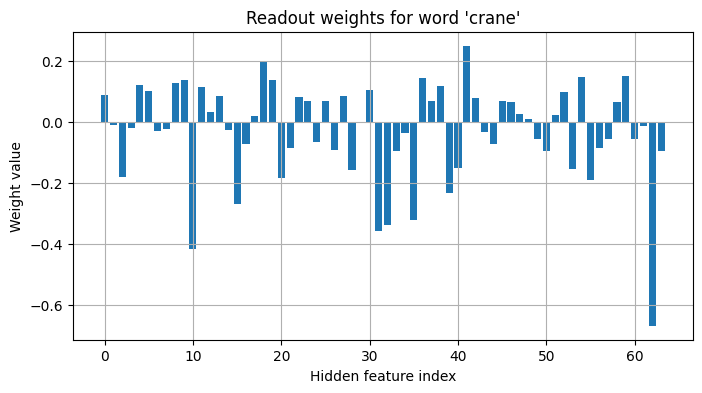

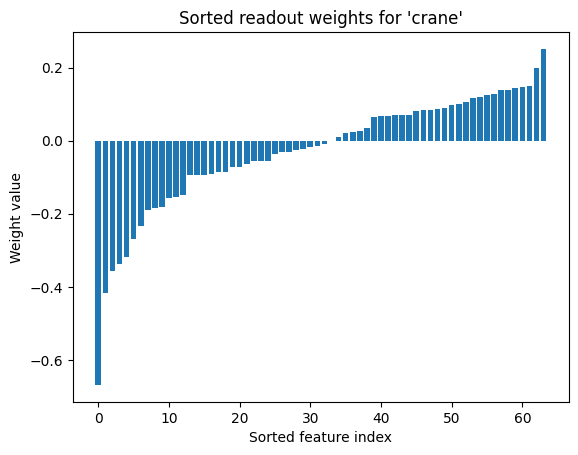

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.bar(range(len(row)), row)  # x = indices, height = row values
plt.title("Readout weights for word 'crane'")
plt.xlabel("Hidden feature index")
plt.ylabel("Weight value")
plt.grid(True)
plt.show()

sorted_idx = np.argsort(row)
plt.bar(range(len(row)), row[sorted_idx])
plt.title("Sorted readout weights for 'crane'")
plt.xlabel("Sorted feature index")
plt.ylabel("Weight value")
plt.show()



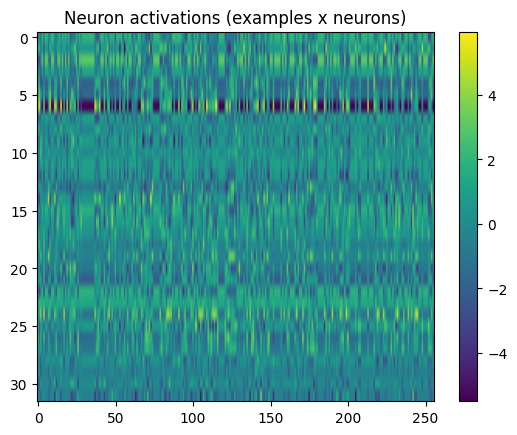

In [3]:
# pick many examples where the teacher must choose between words that differ in a key letter.
# compute token-level activations h (B,L,emb) and visualize mean activations across tokens or neurons.
letters, fbs, y = next(iter(val_dl))
letters, fbs = letters.to(device), fbs.to(device)
logits, h = model(letters, fbs)  # h: [B, L, emb]
act = h.mean(dim=1).cpu().detach().numpy()  # [B, emb]
plt.imshow(act.T, aspect='auto'); plt.colorbar(); plt.title("Neuron activations (examples x neurons)"); plt.show()


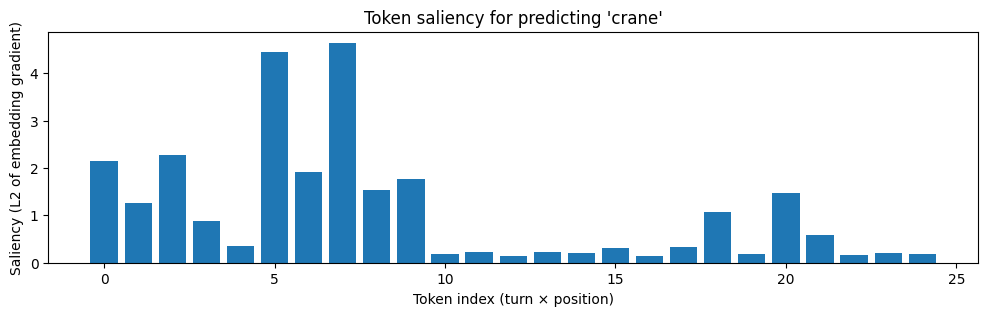

In [10]:
# --- Saliency via torch.autograd.grad (robust) ---
model.eval()

# grab one example
letters, fbs, y = next(iter(val_dl))
letters, fbs = letters.to(device), fbs.to(device)
letters = letters[0:1]   # (1, seq_len)
fbs = fbs[0:1]

# get embeddings (float tensors)
letters_emb = model.letter_emb(letters)   # (1, seq_len, emb)
fbs_emb = model.fb_emb(fbs)               # (1, seq_len, 8)
tok = torch.cat([letters_emb, fbs_emb], dim=-1)    # (1, seq_len, emb+8)
tok = model.token_proj(tok)              # (1, seq_len, emb)
# ensure torch knows we want grads w.r.t. tok
tok.requires_grad_(True)

# forward through the rest of the model using tok as input to transformer:
pos = torch.arange(tok.size(1), device=device).unsqueeze(0)
tok_pos = tok + model.pos_emb(pos)       # (1, seq_len, emb)
h = model.transformer(tok_pos.permute(1,0,2))  # [L,B,emb]
h = h.permute(1,0,2)                     # [B,L,emb]
v = h.mean(dim=1)                        # [B, emb]
logits = model.readout(v)                # [B, V]

# choose word to inspect
target_word = "crane"
score = logits[0, WORD2IDX[target_word]]

# compute gradients of score w.r.t tok
grads = torch.autograd.grad(score, tok)[0]   # shape: (1, seq_len, emb)
grads = grads.detach().cpu().numpy()[0]      # (seq_len, emb)

# aggregate per-token saliency (L2 norm over embedding dim)
saliency_per_token = np.linalg.norm(grads, axis=1)  # (seq_len,)

# plot
plt.figure(figsize=(12,3))
plt.bar(np.arange(len(saliency_per_token)), saliency_per_token)
plt.xlabel("Token index (turn × position)")
plt.ylabel("Saliency (L2 of embedding gradient)")
plt.title(f"Token saliency for predicting '{target_word}'")
plt.show()


Baseline pred: crate true: crate
After zeroing neuron 3: pred: crate
Top probs before (word:prob)  |  after
crate:0.663  |  0.651
trace:0.264  |  0.279
stare:0.072  |  0.069
crane:0.000  |  0.000
there:0.000  |  0.000
store:0.000  |  0.000
glare:0.000  |  0.000
slate:0.000  |  0.000
Baseline val accuracy: 0.3936481404095278


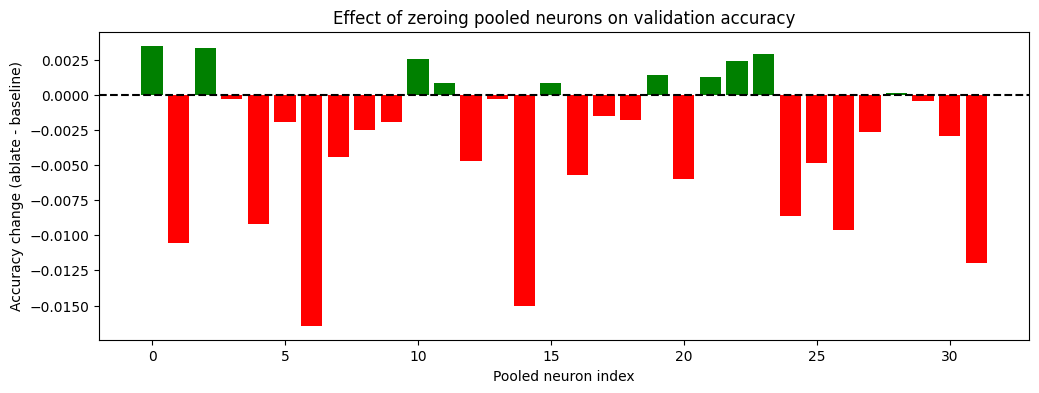

Most harmful ablations (neuron -> delta):
6 -0.01643682964201143
14 -0.015043877977434172
31 -0.011979384315364272
1 -0.010586432650787014
26 -0.009611366485582917
4 -0.009193480986209757
24 -0.008636300320378876
20 -0.005989692157682136


In [12]:
# ---- Utilities to compute pooled vector and do readout separately ----
device = next(model.parameters()).device

def compute_pooled_vector(model, letters, fbs):
    """
    Run the model up to the pooling step and return:
      v: pooled vector of shape [B, emb]
      h: token-level hidden [B, L, emb] (optional, returned for probes)
    """
    # letters: [B, seq_len] (long), fbs: [B, seq_len] (long)
    with torch.no_grad():
        le = model.letter_emb(letters)    # [B,L,emb]
        fe = model.fb_emb(fbs)            # [B,L,8]
        tok = torch.cat([le, fe], dim=-1) # [B,L,emb+8]
        tok = model.token_proj(tok)       # [B,L,emb]
        pos = torch.arange(tok.size(1), device=letters.device).unsqueeze(0).repeat(letters.size(0),1)
        tok = tok + model.pos_emb(pos)    # add pos emb
        h = model.transformer(tok.permute(1,0,2))  # [L,B,emb]
        h = h.permute(1,0,2)              # [B,L,emb]
        v = h.mean(dim=1)                 # [B, emb]
    return v, h

def readout_from_pooled(model, v):
    """
    Apply the model.readout to pooled vector v (no grad) -> logits [B, V]
    """
    with torch.no_grad():
        logits = model.readout(v)  # [B, V]
    return logits

# ---- Single-example neuron ablation test (like your starter single-sample ablation) ----
# pick one sample from val_dl
letters_batch, fbs_batch, y_batch = next(iter(val_dl))
letters_batch = letters_batch.to(device); fbs_batch = fbs_batch.to(device); y_batch = y_batch.to(device)

# choose the first example in the batch to inspect
letters_ex = letters_batch[0:1]; fbs_ex = fbs_batch[0:1]; y_ex = y_batch[0:1]

# baseline prediction
v_orig, _ = compute_pooled_vector(model, letters_ex, fbs_ex)
logits_orig = readout_from_pooled(model, v_orig)
pred_orig = logits_orig.argmax(dim=-1).item()
print("Baseline pred:", IDX2WORD[pred_orig], "true:", IDX2WORD[y_ex.item()])

# ablate neuron i
neuron_to_zero = 3
v_ablate = v_orig.clone()
v_ablate[:, neuron_to_zero] = 0.0
logits_ablate = readout_from_pooled(model, v_ablate)
pred_ablate = logits_ablate.argmax(dim=-1).item()
print(f"After zeroing neuron {neuron_to_zero}: pred:", IDX2WORD[pred_ablate])

# show change in top-5 logits if useful
import numpy as np
probs_orig = torch.softmax(logits_orig, dim=-1).cpu().numpy()[0]
probs_ab = torch.softmax(logits_ablate, dim=-1).cpu().numpy()[0]
topk = 8
print("Top probs before (word:prob)  |  after")
for idx in np.argsort(probs_orig)[-topk:][::-1]:
    print(f"{IDX2WORD[idx]}:{probs_orig[idx]:.3f}  |  {probs_ab[idx]:.3f}")

# ---- Sweep ablation across all pooled neurons (like your starter sweep) ----
def eval_with_neuron_ablation(model, neuron_idx, dataloader):
    """
    Evaluate accuracy on dataloader when pooled neuron neuron_idx is zeroed.
    Returns accuracy (top-1) across full dataloader.
    """
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for letters, fbs, y in dataloader:
            letters = letters.to(device); fbs = fbs.to(device); y = y.to(device)
            v, _ = compute_pooled_vector(model, letters, fbs)   # [B, emb]
            v[:, neuron_idx] = 0.0
            logits = readout_from_pooled(model, v)             # [B, V]
            preds = logits.argmax(dim=-1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

# Baseline accuracy (no ablation)
def evaluate_baseline(model, dataloader):
    model.eval()
    total=0; correct=0
    with torch.no_grad():
        for letters, fbs, y in dataloader:
            letters = letters.to(device); fbs = fbs.to(device); y = y.to(device)
            logits, _ = model(letters, fbs)
            preds = logits.argmax(dim=-1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct/total

baseline_acc = evaluate_baseline(model, val_dl)
print("Baseline val accuracy:", baseline_acc)

# Sweep all pooled dimensions
emb_dim = v_orig.size(1)  # pooled embedding dimension
neuron_indices = list(range(emb_dim))
signed_deltas = []
for i in neuron_indices:
    acc_i = eval_with_neuron_ablation(model, i, val_dl)
    signed_deltas.append(acc_i - baseline_acc)  # drop is negative if accuracy decreases

# Plot signed changes (delta accuracy)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
colors = ['red' if d < 0 else 'green' if d > 0 else 'gray' for d in signed_deltas]
plt.bar(neuron_indices, signed_deltas, color=colors)
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Pooled neuron index")
plt.ylabel("Accuracy change (ablate - baseline)")
plt.title("Effect of zeroing pooled neurons on validation accuracy")
plt.show()

# Print the most impactful neurons (largest negative delta)
deltas = np.array(signed_deltas)
most_harmful = np.argsort(deltas)[:8]   # most negative (harmful ablations)
print("Most harmful ablations (neuron -> delta):")
for i in most_harmful:
    print(i, deltas[i])


In [13]:
for i in range(10):
    letters, fbs, y = next(iter(val_dl))
    letters, fbs, y = letters.to(device), fbs.to(device), y.to(device)
    logits, _ = model(letters, fbs)
    preds = logits.argmax(dim=-1)
    for j in range(5):
        idx = j
        print("Hist:", decode_history(letters[idx], fbs[idx]))  # implement decode helper
        print("Model:", IDX2WORD[preds[idx].item()], "Teacher:", IDX2WORD[y[idx].item()])
        print()
    break


NameError: name 'decode_history' is not defined